In [1]:
%load_ext autoreload
%autoreload 2
%config Completer.use_jedi = False

In [2]:
from datetime import datetime
from pathlib import Path
import pickle
import sys

import matplotlib.pyplot as plt
from pymatgen.core.structure import Molecule

Custom plotting code... ignore this if you don't know what it is, it should gracefully do nothing if you don't have the `MPLAdjutant` class. 

In [14]:
sys.path.append(str(Path.home() / Path("local")))
class NullClass:
    def do_nothing(*args, **kwargs):
        pass
    def add_colorbar(self, im, **kwargs):
        return plt.colorbar(im)
    def __getattr__(self, _):
        return self.do_nothing
try:
    from mpl_utils import MPLAdjutant
    adj = MPLAdjutant()
    adj.set_defaults()
except ImportError:
    adj = NullClass()

Append the `home` path of this project.

In [4]:
sys.path.append(str(Path.cwd().parent))

# Principal component analysis: verifying the data

In this notebook, we perform basic analysis and Principal Component Analysis to validate that our dataset look sensible.

In [5]:
from sklearn.decomposition import PCA

Load in the previously processed `pickle` data. These contain the features (ACSF) and targets (spectra) on a common grid for each of the three absorbing atom types of interest: C, N and O.

In [6]:
O_data = pickle.load(open("../data/qm9/XANES-220622-ACSF-O.pkl", "rb"))
N_data = pickle.load(open("../data/qm9/XANES-220622-ACSF-N.pkl", "rb"))
C_data = pickle.load(open("../data/qm9/XANES-220622-ACSF-C.pkl", "rb"))

Print some diagonstics...

In [7]:
print(f"O database ACSF & spectrum shapes: {O_data['x'].shape} & {O_data['y'].shape}")
print(f"N database ACSF & spectrum shapes: {N_data['x'].shape} & {N_data['y'].shape}")
print(f"C database ACSF & spectrum shapes: {C_data['x'].shape} & {C_data['y'].shape}")

O database ACSF & spectrum shapes: (186813, 155) & (186813, 200)
N database ACSF & spectrum shapes: (139058, 155) & (139058, 200)
C database ACSF & spectrum shapes: (841912, 155) & (841912, 200)


Put everything in a dictionary for simplicity.

In [8]:
data = {"O": O_data, "N": N_data, "C": C_data}

## Execute and plot

In [9]:
pca_results = dict()
for key, dat in data.items():
    pca_acsf = PCA(2)
    w_acsf = pca_acsf.fit_transform(dat["x"])
    pca_spectra = PCA(2)
    w_spectra = pca_spectra.fit_transform(dat["y"])
    pca_results[key] = {
        "pca_ACSF": pca_acsf,
        "pca_spectra": pca_spectra,
        "w_ACSF": w_acsf,
        "w_spectra": w_spectra
    }

In [10]:
pca_results.keys()

dict_keys(['O', 'N', 'C'])

In [11]:
for key, dat in pca_results.items():
    pca_ACSF = dat["pca_ACSF"]
    pca_spectra = dat["pca_spectra"]
    print(f"Key={key}, ACSF var ratios={pca_ACSF.explained_variance_ratio_}, spectra var ratios={pca_spectra.explained_variance_ratio_}")

Key=O, ACSF var ratios=[0.77001979 0.10912827], spectra var ratios=[0.60050381 0.21521107]
Key=N, ACSF var ratios=[0.74167122 0.08957421], spectra var ratios=[0.41484584 0.25633509]
Key=C, ACSF var ratios=[0.61404781 0.1561685 ], spectra var ratios=[0.34132816 0.28826326]


We make a production-quality plot of the data here:

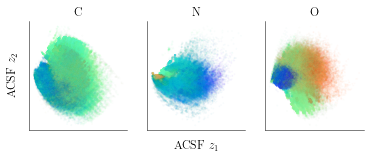

In [12]:
fig, axs = plt.subplots(1, 3, figsize=(6, 2))

N = None
key_ordering = ["C", "N", "O"]

for key, ax in zip(key_ordering, axs):
    w_acsf = pca_results[key]["w_ACSF"]
    w_spectra = pca_results[key]["w_spectra"]
    ax.scatter(w_acsf[:N, 0], w_acsf[:N, 1], alpha=0.02, c=w_spectra[:N, 0], s=1, cmap="rainbow", rasterized=True)
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.spines["left"].set_linewidth(0.5)
    ax.spines["bottom"].set_linewidth(0.5)
    ax.tick_params(left=False, bottom=False)
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.set_title(key)

axs[0].set_ylabel(r"ACSF $z_2$")
axs[1].set_xlabel(r"ACSF $z_1$")
    
plt.savefig("qm9_pca.svg", bbox_inches="tight", dpi=300)

# Train/validation-test split

In [15]:
from xas_nne.qm9 import random_split, split_qm9_data_by_number_of_absorbers

## Random split

In [55]:
for CENTRAL_ATOM in ["C", "N", "O"]:
    parsed_data = random_split(data[CENTRAL_ATOM])
    now = datetime.now().strftime("%y%m%d")
    fname = f"../data/qm9/ml_ready/XANES-{now}-ACSF-{CENTRAL_ATOM}-RANDOM-SPLITS.pkl"
    print(fname)
    pickle.dump(parsed_data, open(fname, "wb"), protocol=pickle.HIGHEST_PROTOCOL)

Original data has 841912 data points
[     0      1      2 ... 841909 841910 841911]
Down-sampled to 833467 data after removing zwitter ions
Done with 750121 train and 83346 test
../data/qm9/ml_ready/XANES-220626-ACSF-C-RANDOM-SPLITS.pkl
Original data has 139058 data points
[     0      1      2 ... 139055 139056 139057]
Down-sampled to 135860 data after removing zwitter ions
Done with 122274 train and 13586 test
../data/qm9/ml_ready/XANES-220626-ACSF-N-RANDOM-SPLITS.pkl
Original data has 183497 data points
[     0      1      2 ... 183494 183495 183496]
Down-sampled to 183497 data after removing zwitter ions
Done with 165148 train and 18349 test
../data/qm9/ml_ready/XANES-220626-ACSF-O-RANDOM-SPLITS.pkl


## Train on molecules with at most `N` absorbers

In [17]:
for CENTRAL_ATOM, max_training_absorbers in zip(["C", "N", "O"], [7, 4, 3]):
    parsed_data = split_qm9_data_by_number_of_absorbers(data[CENTRAL_ATOM], absorber=CENTRAL_ATOM, max_training_absorbers=max_training_absorbers)
    parsed_data["metadata"] = {"max_training_absorbers": max_training_absorbers}
    now = datetime.now().strftime("%y%m%d")
    fname = f"../data/qm9/ml_ready/XANES-{now}-ACSF-{CENTRAL_ATOM}-MAX_TRAINING_ABSORBERS-{max_training_absorbers}.pkl"
    print(fname)
    pickle.dump(parsed_data, open(fname, "wb"), protocol=pickle.HIGHEST_PROTOCOL)

Parsing the qm9 data by number of absorbers=C
Training data will have <=7 absorbers
Test data will get the rest
Keeping zwitterions: False
Computing smiles_to_n_absorbers_map


100%|███████████████████████████████████████████████████████| 133867/133867 [00:02<00:00, 63568.70it/s]


Done with 654084 train and 179383 test
../data/qm9/ml_ready/XANES-220629-ACSF-C-MAX_TRAINING_ABSORBERS-7.pkl
Parsing the qm9 data by number of absorbers=N
Training data will have <=4 absorbers
Test data will get the rest
Keeping zwitterions: False
Computing smiles_to_n_absorbers_map


100%|█████████████████████████████████████████████████████████| 82559/82559 [00:01<00:00, 63875.98it/s]


Done with 130807 train and 5053 test
../data/qm9/ml_ready/XANES-220629-ACSF-N-MAX_TRAINING_ABSORBERS-4.pkl
Parsing the qm9 data by number of absorbers=O
Training data will have <=3 absorbers
Test data will get the rest
Keeping zwitterions: False
Computing smiles_to_n_absorbers_map


100%|███████████████████████████████████████████████████████| 113430/113430 [00:01<00:00, 63703.98it/s]


Done with 179100 train and 4397 test
../data/qm9/ml_ready/XANES-220629-ACSF-O-MAX_TRAINING_ABSORBERS-3.pkl


# Do certain structural motifs cluster?